# BALC cleaning 
## Subset: CEPA files 

2019.02.08 — 2019.02.21

## Summary of code
- Created a corpus dictionary with the file name, original text, and perceived level of proficiency
- Initial set up of cepa_df based off the corpus dictionary, which included
    - Filenames
    - Original Text
- Cleaning up the text for cepa_df by making:
    - A "Normalized" Text with standardized tagging (if applicable)
    - A "Revised" Essay, which removes student correction tags and removes crossed out text
- Building up cepa_df with: 
    - Tokenized essays (built off of the revised essay)
    - Token counts
    - TTR count
- Making sure everything read in correctly
- Visualizing a bit of data about the various levels (token_count, TTR)

## Notes
Prior to February 21, 2019, I was having many issues with the coding system in the BALC corpus, since it is not consistent across all files, or sometimes even within files. Originally, I was trying to process the whole corpus from the "BUiD Arab Learner Corpus v.1/total/" file, which contains every text file in the corpus. What I came to realize is that most of the issues were with a relatively small part of the corpus. Out of 1,865 files in the corpus, non-CEPA files only clock in at 189. Additionally, these files do not come with any proficiency rating. While the proficiency or level rating for the CEPA files are better stated as something along the lines of _perceived proficiency of a student's rating_ (as opposed to be taken as a measure of the student's actual proficency with English), it still serves as a jumping off point and a measure to compare the writing of students in this corpus with students in other corpora.

Therefore, I opted to work from the /total/ folder, for several reasons:
- For one, it has more files than the subsets of CEPA Images folders, and the distribution of files across levels is more even in /total/ than in the CEPA Images folder (as can be seen in my exploration [here](https://github.com/Data-Science-for-Linguists-2019/ESL-Article-Acquisition/blob/master/exploratory-analysis/exploring_balc.ipynb) (compare outputs 3, 4, and 13).
- It is easier to access each file in this file as opposed to the /cepa_#/ folders, which are separated into each individual level.
- Finally, it has content tagged with student error corrections, which could be used to make the essays more comparable, given that these are handwritten essays.
    - So if students realized they used the wrong word/letter and crossed it out, or realized they had forgotten a word and inserted one, this is marked in essays levels 1-4 on CEPA, but _not_ in the CEPA Images folder.
    - In CEPA Images, student corrections are generally ignored, and whatever is written gets put in the text files without taking into account crossing out words/letters, for example.
    - Again, this can be seen in my exploration [in output cell 31](https://github.com/Data-Science-for-Linguists-2019/ESL-Article-Acquisition/blob/master/exploratory-analysis/exploring_balc.ipynb).

So in this notebook, I read in the CEPA files from the corpus, accounting for the "bad" (repeated) files, and then take efforts to normalize, "revise", and clean the essays. I also tokenize, get token counts and TTR, and start on some basic analysis (descriptive and quantitative). There's still more to do: POS-tagging, and maybe lemmatization.

### Initial set-up

In [1]:
import pandas as pd
import numpy as np
import pickle
import nltk
import glob
import re

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%pprint            # to turn off pretty printing

Pretty printing has been turned OFF


In [2]:
cor_dir = "../private/BUiD Arab Learner Corpus v.1/total/"
corpus = glob.glob(cor_dir+'*.txt')
corpus[:5]

['../private/BUiD Arab Learner Corpus v.1/total/CEPA 3 200607296.txt', '../private/BUiD Arab Learner Corpus v.1/total/CEPA 4 200607457.txt', '../private/BUiD Arab Learner Corpus v.1/total/CEPA 5 200600487.txt', '../private/BUiD Arab Learner Corpus v.1/total/CEPA 4 200608016.txt', '../private/BUiD Arab Learner Corpus v.1/total/CEPA 1 200611825.txt']

There are some duplicates in the total folder, which I'm using for the corpus root. The majority of these are cross-listed in two different proficiency levels (a few are in the same folder, but have two different file names with different spacing). 

I was able to locate the correctly labeled files (`clean_files`) in the CEPA Images folder, where all the original handwritten essays are located. Therefore, during my exploration of the corpus, I picked the duplicated (`bad_files`) as well as the clean files. I'll be using these two variables to point my code in the correct direction when it comes to these specific files, so that we don't have essays incorrectly labeled or duplicated files.

In [3]:
# Opening the pickle files that have the problem files... 
f_in = open("duplicated_files.pickle","rb")
bad_files = pickle.load(f_in)
f_in.close()

# ... and the clean files
f_in = open("clean_files.pickle","rb")
clean_files = pickle.load(f_in)
f_in.close()

# checking the variables and making sure this looks right
bad_files
clean_files

['200607856', '200607880', '200607857', '200607777', '200607875', '200607861', '200607902', '200607910', '200612324', '200611115', '200621158', '200619773']

['../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607777.jpg', '../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607856.jpg', '../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607880.jpg', '../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607857.jpg', '../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200612324.jpg', '../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607902.jpg', '../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607861.jpg', '../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607875.jpg', '../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607910.jpg', '../private/BUiD Arab Learner Corpus v.1/CEPA Images/3/200611115.jpg', '../private/BUiD Arab Learner Corpus v.1/CEPA Images/6/200621158.jpg', '../private/BUiD Arab Learner Corpus v.1/CEPA Images/6/200619773.jpg']

Yes, those are looking good! `bad_files` is a list of the duplicated files, and `clean_files` is the list of the correct location. The `clean_files` gives us which location in total we should head to to get the file (e.g. level 2, if a file is cross-listed in levels 1 and 2).

Let's make sure the code will spit out the correct file.

In [4]:
# Making sure the code will pull the correct file for the duplicated files -- we're reading from /total/, but we can get the nececssary information from these filenames
# we'll need the two numbers after "CEPA Images": the first number is the level, and the second number is the "short" file name we'll be using
for item in clean_files:
    if any(search in item for search in bad_files):
        print("use:", item)

use: ../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607777.jpg
use: ../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607856.jpg
use: ../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607880.jpg
use: ../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607857.jpg
use: ../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200612324.jpg
use: ../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607902.jpg
use: ../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607861.jpg
use: ../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607875.jpg
use: ../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607910.jpg
use: ../private/BUiD Arab Learner Corpus v.1/CEPA Images/3/200611115.jpg
use: ../private/BUiD Arab Learner Corpus v.1/CEPA Images/6/200621158.jpg
use: ../private/BUiD Arab Learner Corpus v.1/CEPA Images/6/200619773.jpg


In [5]:
# setting up a cepa dict
corpus = glob.glob(cor_dir+'*.txt')
corpus_dict = {}
for file in corpus:
    start = file.rindex('/')+1
    name = file[start:-4]
    x = re.findall(r'^((C|c).*?\d{3,}( -)?)', name)   
    if len(x) > 0:
            x = x[0][0].split()
            if x[-1] not in bad_files:  # duplicated files - ignoring them for now, will put in a separate dict and concatenate
                f = open(file, encoding='utf-8-sig')   # fixes \ufeff code at beginning of strings
                txt = f.read()
                f.close()
                corpus_dict[x[-1]] = {"Level": x[1], "Text": txt}
len(corpus_dict.keys())

1652

In [6]:
corpus_dict["200601970"]

{'Level': '1', 'Text': '\t\t\t\tCEPA 1 200601970\n\n\n\nYou have just had the perfect holiday you went Yaman There go <o>my  father and my brather. You</o> saw and did hadr<o>a</o> mot and sanaa moll. It was so wonderful m<o>y</o> famely\n'}

In [7]:
corpus_dict["200600215"]["Level"]

'5'

In [8]:
corpus_dict["200600215"]

{'Level': '5', 'Text': '\t\t\t\tCEPA 5 200600215\n\n\n\nLast summer holiday was the worst holiday I have ever had. It was bad holiday because evrythings happened suddenly and without any prepairing.\nLast summer holiday, my family decided to spend  the holiday in India, so my father booked us a tickets to India. We all prepaired the bags for travelling on Tuesday.\nWe were on the airport befor one hour of plane flying. We were told that the plane had something wrong and it would be late. We waited for three hours in the airport. Then, we flew to India. It took us three hours. When we arrived we started looking for taxi for a long time. After that we found small bus to take us to the hotel. \nIn the way of the hotel, I saw many dogs in the street and I was afraid. In the entrence of the hotel there were many poor children with dirty cats. We spent this day in hotel because of  the bad weather.\nNext day, I suggested going to the park. My father bought the lunch and took us to the park. 

In [9]:
# This is for the bad files. There should be twelve of them!
mini = {}
for item in clean_files:
    if any(search in item for search in bad_files):
        x = re.findall(r'\d/\d+', item)   # gets the level (/\d/) and the file (\d+) information
        x = x[0]
        x = x.split('/')
        fn = cor_dir+"CEPA "+str(x[0])+" "+str(x[1])+".txt"
        print(x, fn)
        f = open(fn, encoding='utf-8-sig')
        txt = f.read()
        f.close()
        mini[x[1]] = {"Level": x[0], "Text": txt}
len(mini.keys())
mini['200607777']["Text"]

['2', '200607777'] ../private/BUiD Arab Learner Corpus v.1/total/CEPA 2 200607777.txt
['2', '200607856'] ../private/BUiD Arab Learner Corpus v.1/total/CEPA 2 200607856.txt
['2', '200607880'] ../private/BUiD Arab Learner Corpus v.1/total/CEPA 2 200607880.txt
['2', '200607857'] ../private/BUiD Arab Learner Corpus v.1/total/CEPA 2 200607857.txt
['2', '200612324'] ../private/BUiD Arab Learner Corpus v.1/total/CEPA 2 200612324.txt
['2', '200607902'] ../private/BUiD Arab Learner Corpus v.1/total/CEPA 2 200607902.txt
['2', '200607861'] ../private/BUiD Arab Learner Corpus v.1/total/CEPA 2 200607861.txt
['2', '200607875'] ../private/BUiD Arab Learner Corpus v.1/total/CEPA 2 200607875.txt
['2', '200607910'] ../private/BUiD Arab Learner Corpus v.1/total/CEPA 2 200607910.txt
['3', '200611115'] ../private/BUiD Arab Learner Corpus v.1/total/CEPA 3 200611115.txt
['6', '200621158'] ../private/BUiD Arab Learner Corpus v.1/total/CEPA 6 200621158.txt
['6', '200619773'] ../private/BUiD Arab Learner Corpus

12

'\t\t\t\tCEPA 2 200607777\n\n\n\nThe perfet holiday in UAE. You went suren cantres to one holiday. went with you me sister and mather. I’m see in Abu Dhabie “shate alraha” is a very nice sea and I went “Al maryna moll”. alfter is going to AlAin. it very nice, I went “  Mouten of hafied” and “mobazar AlKadra”. In Dubai went to the “meina salam” and “almaha” is a nice hotiel in Dubai. In RAK is go in masafi and see the water of masafi. wheth alfugaira isvery nise cantry because is have more of mouten”\nThe ajnan amalguin is avery smoler than save cantres. it was so wonderful because I’m going xxx with father and sister. went to sven emarit. I’m very happey to see emarat in  one holiday.\n'

In [10]:
# Concatenating corpus_dict and mini, making sure they have the right amount of keys
z = {**corpus_dict, **mini}
len(z.keys())

# Yes! We have gone down from the original 1676 files found in the total and individual cepa_# folders, but that's because we took out the duplicates in those folders

1664

##### Setting up the DataFrame

In [11]:
cepa_df = pd.DataFrame(list(z.keys()), columns={"Filename"})
cepa_df.shape
cepa_df.head()

(1664, 1)

,Filename
0,200607296
1,200607457
2,200600487
3,200608016
4,200611825


In [12]:
# UDFs to get the level and the original text
def get_level(file):
    return z[file]["Level"]

def get_text(file):
    return z[file]["Text"]

In [13]:
cepa_df["Level"] = cepa_df.Filename.apply(get_level)
cepa_df["Original_Text"] = cepa_df.Filename.apply(get_text)
cepa_df.head()

,Filename,Level,Original_Text
0,200607296,3,\t\t\t\tCEPA 3 200607296\n\n\n\nNow I tell you...
1,200607457,4,\t\t\t\tCEPA 4 200607457\n\n\n\n ...
2,200600487,5,\t\t\t\tCEPA 5 200600487\n\n\n\n\nEvery body i...
3,200608016,4,\t\t\t\tCEPA 4 200608016\n\n\n\nEvery body hav...
4,200611825,1,\t\t\t\tCEPA 1 200611825\n\n\n\nyou go in the ...


### Cleaning data up
It's time to get clean up these files! We can see from the DataFrame and dict entries above that these files all have a lot of white space, as well as a header with the file name. We don't need that! 

In this section, I:
- Remove excessive whitespace
- Remove things like curly quotes 
- Standardize tagging
    - `<o>...</o>` -> `_`
    - `<i>...</i>` -> `^`
    - `<x>...</x>` -> `~~`

In [14]:
# Making UDFs to clean up data a bit

# Remove whitespace and strange characters found in some of the files
def clean_text(txt):
    """Removes excessive whitespace, backticks, and curly quotes from a text."""
    txt = re.sub(r'[\n\t ]+', ' ', txt)
    txt = re.sub(r'^`', '', txt)
    txt = txt.replace('“','"').replace('”','"').replace("’", "'")
    txt = txt.strip()
    return txt

# Retag files, dealing with unclosed tags, and making it easier to remove these tags later -- instead of looking for 6+ opening and closing tags, I just need to look for underscores, carrots, and the double tildes tags
def retag(essay):
    """Replaces tags for student emphasis (<o>, </o>)with '_' and removes any unecessary spaces between emphasized 
    letters in words. Replaces tags for student insertions (<i>, </i>) with '^' and removes any unecessary spaces 
    between letters in inserted words. Replaces cross-out tags (<x>, </x>) with '~~' Removes any left over brackets."""
    essay = re.sub(r'\<i +', '<i>', essay)
    essay = re.sub(r'<x +', '<x>', essay)
    essay = re.sub(r'<o +', '<o>', essay)
    essay = re.sub(r'<\/o[^>]', '</o>', essay)
    essay = re.sub(r'<o>(\s)?', '_', essay)
    essay = re.sub(r'(\s)?<\/o>', '_', essay)
    essay = re.sub(r'<i>(\s)?', '^', essay)
    essay = re.sub(r'(\s)?<\/i>', '^', essay)
    essay = re.sub(r'</?x>', '~~', essay)
    essay = re.sub(r'>', ' ', essay)
    essay = re.sub(r'<', ' ', essay)
#    essay = re.sub(r'__', '_ _', essay)
    return essay

# Remove heading from files
def un_head(txt):
    """Removes headers from text that include the file name, as well as student's names, grades, schools, etc."""
    cepa = re.compile(r'^C(EPA|EPa|epa)')      # removes cepa headers
    if cepa.search(txt):
        txt = re.sub(r'CEPA.*?\d{2,}( ?-)?', '', txt, flags=re.I)   # there was one file that was CEPA ! filename
    return txt

# Apply all of these UDFs in a convenient, single function!
def normalize_essay(txt):
    txt = clean_text(txt)
    txt = retag(txt)
    txt = un_head(txt)
    txt = txt.strip()
    return txt

Now let's check the UDFs out to make sure they work!

In [15]:
# Original file
cepa_df.Original_Text[137]
cepa_df.Original_Text[1524]

'\t\t\t\tCEPA 1 2006625\n\n\n\nwhat the activity is to ideas and to Play foot ball in the clamp and see to manh in T.V of foot ball Games Iam we play move foor ball in the zoo with may fired XXX I paly in the\nFradey <o>a</o>t 4 coclek is too storing of tham am and to ray ferar<o>d</o>e  in the Zoo as behtFele sprts in any am and I go may fired to see foot ball in clarp in LAwqL Calmp Iam more afeh see footpall amy fired and go to the coFe see foot ball an gierk to cof and wentes and go to may clamp see may pephel play fotb<o>a</o>ll im clamp and me I kan paly more Gams in the comfotre Games\nin cold places they culive by living with humans.\n'

"\t\t\t\tCEPA 2 200606375\n\n\n\nthe most beau<o>u</otiful pla<x>c</x>e you know in <o>A</o>l Hilly . I like go to the allh<x>i</x>lly because I'm play geam and look in the most beautiful . I play foot ball , tens basketball and play geam to t<x>h</x>e car . I'm look to the sea. I'm go to the AllHilly on frend .your go in the play <o>and aet</o>. I should you go in the All Hilly sawfa li<x>k</x>e and love . because in the be<x>a</x>utiful place. why I like it so much ? <x>beaucse</x> beautiful place and I'm go to AllHelly only Time. what you do eat ?? I'm eat to Hamborgar , Frish and Asier .Thnke you.\n"

In [16]:
# Cleaning it
clean_text(cepa_df.Original_Text[137])
clean_text(cepa_df.Original_Text[1524])

'CEPA 1 2006625 what the activity is to ideas and to Play foot ball in the clamp and see to manh in T.V of foot ball Games Iam we play move foor ball in the zoo with may fired XXX I paly in the Fradey <o>a</o>t 4 coclek is too storing of tham am and to ray ferar<o>d</o>e in the Zoo as behtFele sprts in any am and I go may fired to see foot ball in clarp in LAwqL Calmp Iam more afeh see footpall amy fired and go to the coFe see foot ball an gierk to cof and wentes and go to may clamp see may pephel play fotb<o>a</o>ll im clamp and me I kan paly more Gams in the comfotre Games in cold places they culive by living with humans.'

"CEPA 2 200606375 the most beau<o>u</otiful pla<x>c</x>e you know in <o>A</o>l Hilly . I like go to the allh<x>i</x>lly because I'm play geam and look in the most beautiful . I play foot ball , tens basketball and play geam to t<x>h</x>e car . I'm look to the sea. I'm go to the AllHilly on frend .your go in the play <o>and aet</o>. I should you go in the All Hilly sawfa li<x>k</x>e and love . because in the be<x>a</x>utiful place. why I like it so much ? <x>beaucse</x> beautiful place and I'm go to AllHelly only Time. what you do eat ?? I'm eat to Hamborgar , Frish and Asier .Thnke you."

In [17]:
# Un-heading the cleaned file
un_head(clean_text(cepa_df.Original_Text[137]))
un_head(clean_text(cepa_df.Original_Text[1524]))

' what the activity is to ideas and to Play foot ball in the clamp and see to manh in T.V of foot ball Games Iam we play move foor ball in the zoo with may fired XXX I paly in the Fradey <o>a</o>t 4 coclek is too storing of tham am and to ray ferar<o>d</o>e in the Zoo as behtFele sprts in any am and I go may fired to see foot ball in clarp in LAwqL Calmp Iam more afeh see footpall amy fired and go to the coFe see foot ball an gierk to cof and wentes and go to may clamp see may pephel play fotb<o>a</o>ll im clamp and me I kan paly more Gams in the comfotre Games in cold places they culive by living with humans.'

" the most beau<o>u</otiful pla<x>c</x>e you know in <o>A</o>l Hilly . I like go to the allh<x>i</x>lly because I'm play geam and look in the most beautiful . I play foot ball , tens basketball and play geam to t<x>h</x>e car . I'm look to the sea. I'm go to the AllHilly on frend .your go in the play <o>and aet</o>. I should you go in the All Hilly sawfa li<x>k</x>e and love . because in the be<x>a</x>utiful place. why I like it so much ? <x>beaucse</x> beautiful place and I'm go to AllHelly only Time. what you do eat ?? I'm eat to Hamborgar , Frish and Asier .Thnke you."

In [18]:
retag(un_head(clean_text(cepa_df.Original_Text[137])))
retag(un_head(clean_text(cepa_df.Original_Text[1524])))

' what the activity is to ideas and to Play foot ball in the clamp and see to manh in T.V of foot ball Games Iam we play move foor ball in the zoo with may fired XXX I paly in the Fradey _a_t 4 coclek is too storing of tham am and to ray ferar_d_e in the Zoo as behtFele sprts in any am and I go may fired to see foot ball in clarp in LAwqL Calmp Iam more afeh see footpall amy fired and go to the coFe see foot ball an gierk to cof and wentes and go to may clamp see may pephel play fotb_a_ll im clamp and me I kan paly more Gams in the comfotre Games in cold places they culive by living with humans.'

" the most beau_u_iful pla~~c~~e you know in _A_l Hilly . I like go to the allh~~i~~lly because I'm play geam and look in the most beautiful . I play foot ball , tens basketball and play geam to t~~h~~e car . I'm look to the sea. I'm go to the AllHilly on frend .your go in the play _and aet_. I should you go in the All Hilly sawfa li~~k~~e and love . because in the be~~a~~utiful place. why I like it so much ? ~~beaucse~~ beautiful place and I'm go to AllHelly only Time. what you do eat ?? I'm eat to Hamborgar , Frish and Asier .Thnke you."

Now let's check `normalize()`. It goes a step farther by retagging the HTML codes. This was giving me a lot of trouble earlier! Sometimes it will link words that shouldn't be linked (e.g. "\_to_do" instead of "\_to_ do".

In [19]:
normalize_essay(cepa_df.Original_Text[15])

'Topic _A_ I will writing this a Prerf in far_mer_ in AlAin, who you were of father and mother and ster You did Planing foot dall . happened to watah camall and ive it was so had XXX Donka you like it so much'

In [20]:
normalize_essay(cepa_df.Original_Text[137])

'what the activity is to ideas and to Play foot ball in the clamp and see to manh in T.V of foot ball Games Iam we play move foor ball in the zoo with may fired XXX I paly in the Fradey _a_t 4 coclek is too storing of tham am and to ray ferar_d_e in the Zoo as behtFele sprts in any am and I go may fired to see foot ball in clarp in LAwqL Calmp Iam more afeh see footpall amy fired and go to the coFe see foot ball an gierk to cof and wentes and go to may clamp see may pephel play fotb_a_ll im clamp and me I kan paly more Gams in the comfotre Games in cold places they culive by living with humans.'

### Expanding on cepa_df

In this section, I will:
- Normalize essays with UDFs created in previous section
- Make "Revised_essay", which removes all tagging
- Tokenize (based on revised_essay)
- Get token counts (based on revised_essay)
- Get TTR (based on revised_essay)

In [21]:
cepa_df['Normalized_Essay'] = cepa_df.Original_Text.apply(normalize_essay)
cepa_df.head()

,Filename,Level,Original_Text,Normalized_Essay
0,200607296,3,\t\t\t\tCEPA 3 200607296\n\n\n\nNow I tell you...,Now I tell you why my worst holiday ever in th...
1,200607457,4,\t\t\t\tCEPA 4 200607457\n\n\n\n ...,My worst holiday Last year I have just had the...
2,200600487,5,\t\t\t\tCEPA 5 200600487\n\n\n\n\nEvery body i...,Every body in this life have a favourite posse...
3,200608016,4,\t\t\t\tCEPA 4 200608016\n\n\n\nEvery body hav...,Every body have a lot ofpossessions in this li...
4,200611825,1,\t\t\t\tCEPA 1 200611825\n\n\n\nyou go in the ...,you go in the oman just had the perfect holida...


In [22]:
cepa_df[cepa_df.Normalized_Essay.str.contains(r'_\w{2,}')]

,Filename,Level,Original_Text,Normalized_Essay
0,200607296,3,\t\t\t\tCEPA 3 200607296\n\n\n\nNow I tell you...,Now I tell you why my worst holiday ever in th...
1,200607457,4,\t\t\t\tCEPA 4 200607457\n\n\n\n ...,My worst holiday Last year I have just had the...
3,200608016,4,\t\t\t\tCEPA 4 200608016\n\n\n\nEvery body hav...,Every body have a lot ofpossessions in this li...
9,200611351,3,\t\t\t\tCEPA 3 200611351\n\n\n\nAl_ain mall is...,Al_ain mall is the most beautiful place. First...
15,200603206,1,\n\t\t\t\tCEPA 1 200603206\n\n\n\n Topi...,Topic _A_ I will writing this a Prerf in far_m...
16,200611379,3,\t\t\t\tCEPA 3 200611379\n\n\n\n\nI spend my w...,I spend my weekend in Dubai. I go with my fami...
18,200611190,3,\t\t\t\tCEPA 3 200611190\n\n\n\nThere are many...,There are many things make the worst holiday f...
19,200606353,2,\t\t\t\tCEPA 2 200606353\n\n\n\nI m Love the U...,I m Love the UAE the UAE I am very very Love t...
23,200601400,2,\t\t\t\tCEPA 2 200601400\n\n\n\nI have just ha...,I have just had the worst holiday ever . The h...
24,200601414,2,\t\t\t\tCEPA 2 200601414\n\n\n\n<o>I am go to ...,_I am go to the_sumar holabuy in The Oman in t...


In [23]:
cepa_df[cepa_df.Normalized_Essay.str.contains(r'[<>]')]

,Filename,Level,Original_Text,Normalized_Essay


In [24]:
cepa_df.Original_Text[214]
cepa_df.Normalized_Essay[214]

'\t\t\t\tCEPA 3 200606808\n\n\n\nA Good day ti go the picnicto a Al Ain, I am go wiht my friend , I say them "i <x>s</x>ee you in the M<x>e</x>ga Mall t<x>o</x> begin th picnic toworoion" In 8.30 A.M I meet my fi<x>r</x>iend he say " I want breakfast I am don\'t e<o>a</o>ten <o><it </o>" , I say "O.K le<x>t\'s</x> go to the fastfood, i<x>t h</x>as eiar the mall " we began the picnic, I the street my firend say"Al Ain a wanderful cityI would go the AlHale park", than I say " It\'s good iea<o>sc</o> let\'s go ther" than I <x>am</x> see Al Ain cit<x>y</x> than I go to xxx the park ,I around the AlHafet montrain in 6.00pm I say my fi<x>r</x>end " let\'s go bark and sharjah "I say my selt " The picnic it\'s wonderful picnic I se<x>e</x> in the park a football ground, the cinldren play ground and an AlHafet mountrain I see the <x>w</x>o<x>n</x>derful reck I get them for my father he like the rock "it\'s my picnis .\n'

'A Good day ti go the picnicto a Al Ain, I am go wiht my friend , I say them "i ~~s~~ee you in the M~~e~~ga Mall t~~o~~ begin th picnic toworoion" In 8.30 A.M I meet my fi~~r~~iend he say " I want breakfast I am don\'t e_a_ten _ it_" , I say "O.K le~~t\'s~~ go to the fastfood, i~~t h~~as eiar the mall " we began the picnic, I the street my firend say"Al Ain a wanderful cityI would go the AlHale park", than I say " It\'s good iea_sc_ let\'s go ther" than I ~~am~~ see Al Ain cit~~y~~ than I go to xxx the park ,I around the AlHafet montrain in 6.00pm I say my fi~~r~~end " let\'s go bark and sharjah "I say my selt " The picnic it\'s wonderful picnic I se~~e~~ in the park a football ground, the cinldren play ground and an AlHafet mountrain I see the ~~w~~o~~n~~derful reck I get them for my father he like the rock "it\'s my picnis .'

In [25]:
cepa_df.Original_Text[1524]

"\t\t\t\tCEPA 2 200606375\n\n\n\nthe most beau<o>u</otiful pla<x>c</x>e you know in <o>A</o>l Hilly . I like go to the allh<x>i</x>lly because I'm play geam and look in the most beautiful . I play foot ball , tens basketball and play geam to t<x>h</x>e car . I'm look to the sea. I'm go to the AllHilly on frend .your go in the play <o>and aet</o>. I should you go in the All Hilly sawfa li<x>k</x>e and love . because in the be<x>a</x>utiful place. why I like it so much ? <x>beaucse</x> beautiful place and I'm go to AllHelly only Time. what you do eat ?? I'm eat to Hamborgar , Frish and Asier .Thnke you.\n"

In [26]:
cepa_df.Normalized_Essay[24]
cepa_df.Original_Text[24]

# Yes, we can see "the" and "sumar" are connected in the phrase "I am go in the sumar" -- but that was in the original text, so that's probably not an error created by me

'_I am go to the_sumar holabuy in The Oman in the Slala in my family the Salala is very haphe and go to The Oman in The car on my calal becoues is not go in the sun and becoues people go in Oman go to the sea and the swming ,eating in Faham beoue_s_ is bleshes food in the brth_a_r in the very nais in the swmming and go the play foot ple and go to the santar in the shoping and go to the Zoo is very naies and becoues in the manke and lion and tor to us in the anmils and go to The hotel go the slep. becous go to in The Famliy is very nais and is very haply'

'\t\t\t\tCEPA 2 200601414\n\n\n\n<o>I am go to the</o>sumar holabuy in The Oman in the Slala in my family the Salala is very haphe and go to The Oman in The car on my calal becoues is not go in the sun and becoues people go in Oman go to the sea and the swming ,eating in Faham beoue<o>s</o> is bleshes food in the brth<o>a</o>r in the very nais in the swmming and go the play foot ple and go to the santar in the shoping and go to the Zoo is very naies and becoues in the manke and lion and tor to us in the anmils and go to The hotel go the slep. becous go to in The Famliy is very nais and is very haply\n'

In [27]:
cepa_df.Original_Text[69]
cepa_df.Normalized_Essay[69]

'\t\t\t\tCEPA 2 200605920\n\n\n\nMy live in the Shajohe, A house is very beautiful, 2 rezens  <i>for righting</i>\nThe houses in the <o>fife</o> romes, I like rome is me .\nFirse, be<x>c</x>uos a beautiful my rome, I like the rome becous the see are me bar play in rome and eat \nSacend,\n'

'My live in the Shajohe, A house is very beautiful, 2 rezens ^for righting^ The houses in the _fife_ romes, I like rome is me . Firse, be~~c~~uos a beautiful my rome, I like the rome becous the see are me bar play in rome and eat Sacend,'

In [28]:
# UDF to remove tags -- removes tagging for insertions and emphasis, and removes anything within a cross-out tag
def remove_tags(text):
    """Removes tags from Normalized_Essay. If there are tags indicating a student crossed something out, whatever is 
    enclosed in those tags is removed."""
    text = re.sub(r'~~.*?~~', '', text)         # delete tags for crossing out and the text in those tags
    text = text.replace('_', '').replace('^', '')   # remove emphasis and insertion tags
    return text

In [29]:
# Remove_tags applied to creat "Revised_Essay"
# Tokenize revised_essay
# Get token count
cepa_df['Revised_Essay'] = cepa_df.Normalized_Essay.apply(remove_tags)
cepa_df['tokens'] = cepa_df.Revised_Essay.apply(nltk.word_tokenize)
cepa_df['token_count'] = cepa_df.tokens.map(len)
cepa_df.sample(15)

,Filename,Level,Original_Text,Normalized_Essay,Revised_Essay,tokens,token_count
1340,200607088,3,\t\t\t\tCEPA 3 200607088\n\nxxx No body can de...,xxx No body can deny how I spent my summer hol...,xxx No body can deny how I spent my summer hol...,"[xxx, No, body, can, deny, how, I, spent, my, ...",79
1169,200610975,3,\t\t\t\tCEPA 3 200610975\n\n\n\nI had the wors...,I had the worst holiday ever. _I_ went to the ...,"I had the worst holiday ever. I went to the ,...","[I, had, the, worst, holiday, ever, ., I, went...",152
46,200601835,5,\t\t\t\tCEPA 5 200601835\n\n\n\nLast year I ha...,Last year I had my worst summer holiday. I tra...,Last year I had my worst summer holiday. I tra...,"[Last, year, I, had, my, worst, summer, holida...",217
1560,200680259,6,\t\t\t\tCEPA 6 200680259\n\n\n\nThrough out li...,"Through out life people posses many stuff, som...","Through out life people posses many stuff, som...","[Through, out, life, people, posses, many, stu...",245
1633,200608835,1,\t\t\t\tCEPA 1 200608835\n\n\n\nI go in the sa...,I go in the safa park,I go in the safa park,"[I, go, in, the, safa, park]",6
482,200607970,4,\t\t\t\tCEPA 4 200607970\n\n\n\nOne day whew I...,One day whew I was in a grade 11 my mother dec...,One day whew I was in a grade 11 my mother dec...,"[One, day, whew, I, was, in, a, grade, 11, my,...",192
500,200607804,4,\t\t\t\tCEPA 4 200607804\n\n\n\nLast summer I...,Last summer I had a very nice holiday .It was ...,Last summer I had a very nice holiday .It was ...,"[Last, summer, I, had, a, very, nice, holiday,...",271
326,200600469,5,\t\t\t\tCEPA 5 200600469\n\n\n\nI think the im...,I think the imagine is very important and enjo...,I think the imagine is very important and enjo...,"[I, think, the, imagine, is, very, important, ...",211
256,200608142,5,\t\t\t\tCEPA 5 200608142\n\n\n\nI think everyo...,I think everyone should spend a nice and beaut...,I think everyone should spend a nice and beaut...,"[I, think, everyone, should, spend, a, nice, a...",278
1372,200605666,4,\t\t\t\tCEPA 4 200605666\n\n\n\n My hap...,My happy holiday Any people should spend thier...,My happy holiday Any people should spend thier...,"[My, happy, holiday, Any, people, should, spen...",206


In [30]:
# checking to make sure there are no "cepa" tokens included from incorrect/incomplete heading removal
cepa_df[cepa_df.tokens.apply(lambda x: 'cepa' in [y.lower() for y in x])]

# returns are essays that talk about cepa 

,Filename,Level,Original_Text,Normalized_Essay,Revised_Essay,tokens,token_count
6,200608959,5,\t\t\t\tCEPA 5 200608959\n\n\n\nI have just ha...,I have just had the perfect and the best holid...,I have just had the perfect and the best holid...,"[I, have, just, had, the, perfect, and, the, b...",277
128,200612443,2,\t\t\t\tCEPA 2 200612443\n\n\n\nI’m writing To...,I'm writing Topic B to Describe the best film ...,I'm writing Topic B to Describe the best film ...,"[I, 'm, writing, Topic, B, to, Describe, the, ...",310
237,200611155,3,\t\t\t\tCEPA 3 200611155\n\n\n\nIn the last su...,"In the last summer holiday, I hade the worest ...","In the last summer holiday, I hade the worest ...","[In, the, last, summer, holiday, ,, I, hade, t...",264
812,200612584,2,\t\t\t\tCEPA 2 200612584\n\n\n\nThese weekend ...,These weekend the worst. Because I stayd at ho...,These weekend the worst. Because I stayd at ho...,"[These, weekend, the, worst, ., Because, I, st...",52
1251,200611303,3,\t\t\t\tCEPA 3 200611303\n\n\n\nThere are many...,There are many qualites the worst weekend bad....,There are many qualites the worst weekend bad....,"[There, are, many, qualites, the, worst, weeke...",199
1401,200604402,1,\t\t\t\tCEPA 1 200604402\n\n\n\n<x>me</x> <o>m...,~~me~~ _my you went ar_wous. went ~~my~~ and f...,my you went arwous. went and fraund Yor ne...,"[my, you, went, arwous, ., went, and, fraund, ...",42


Great! Let's keep truckin' along!

In [31]:
# Let's get TTR
def get_TTR(toks):
    """All tokens are lowercased, punctuation is included.
    Get TTR by dividing set of lowercased tokens by length of tokens."""
    all_toks = [x.lower() for x in toks]
    if len(all_toks) == 0:   # at least one file has 0 tokens, so I got an error about dividing by zero without this
        return 0
    else: return len(set(all_toks))/len(all_toks)

In [32]:
# checking UDF
foo = "My name is Elena and I am a Junior Linguist. I study applied linguistics, and i want to be a linguist."
get_TTR(foo.split())

0.7619047619047619

In [33]:
# checking UDF by hand
lil = [x.lower() for x in foo.split()]
len(set(lil))/len(lil)

0.7619047619047619

In [34]:
# checking UDF on an empty string
foo = ""
get_TTR(foo)

0

In [35]:
cepa_df['TTR'] = cepa_df.tokens.apply(get_TTR)

In [36]:
cepa_df.head()

,Filename,Level,Original_Text,Normalized_Essay,Revised_Essay,tokens,token_count,TTR
0,200607296,3,\t\t\t\tCEPA 3 200607296\n\n\n\nNow I tell you...,Now I tell you why my worst holiday ever in th...,Now I tell you why my worst holiday ever in th...,"[Now, I, tell, you, why, my, worst, holiday, e...",207,0.492754
1,200607457,4,\t\t\t\tCEPA 4 200607457\n\n\n\n ...,My worst holiday Last year I have just had the...,My worst holiday Last year I have just had the...,"[My, worst, holiday, Last, year, I, have, just...",180,0.572222
2,200600487,5,\t\t\t\tCEPA 5 200600487\n\n\n\n\nEvery body i...,Every body in this life have a favourite posse...,Every body in this life have a favourite posse...,"[Every, body, in, this, life, have, a, favouri...",229,0.445415
3,200608016,4,\t\t\t\tCEPA 4 200608016\n\n\n\nEvery body hav...,Every body have a lot ofpossessions in this li...,Every body have a lot ofpossessions in this li...,"[Every, body, have, a, lot, ofpossessions, in,...",156,0.608974
4,200611825,1,\t\t\t\tCEPA 1 200611825\n\n\n\nyou go in the ...,you go in the oman just had the perfect holida...,you go in the oman just had the perfect holida...,"[you, go, in, the, oman, just, had, the, perfe...",27,0.629630


### Descriptives
Here, I do two things: I make sure everything is read in correctly, and I look at some basic descriptive stats for the DataFrame, such as the descriptions of token count, TTR, and value counts for the different levels.

In [37]:
# all filenames should have only 1 value
all(cepa_df.Filename.value_counts() == 1)

True

In [38]:
# Size of the DataFrame as is
cepa_df.shape

(1664, 8)

In [39]:
# Levels should be 1-6 only
set(cepa_df.Level)

{'2', '6', '5', '4', '3', '1'}

In [40]:
# should be 1664 counts for everything -- at least 1 token_count of 0
cepa_df.describe()

,token_count,TTR
count,1664.000000,1664.000000
mean,160.146635,0.546312
std,86.137210,0.115905
min,0.000000,0.000000
25%,85.000000,0.471569
50%,164.000000,0.522902
75%,224.000000,0.590166
max,397.000000,1.000000


In [41]:
# Let's review the number of files for each level
cepa_df.Level.value_counts()

5    299
4    297
2    292
1    276
3    250
6    250
Name: Level, dtype: int64

In [42]:
# Let's see how many files have no tokens
cepa_df[cepa_df.token_count == 0]

# Just 1! and it's a level 1

,Filename,Level,Original_Text,Normalized_Essay,Revised_Essay,tokens,token_count,TTR
1079,200604511,1,\t\t\t\tCEPA 1 200604511\n\n\n\n\n,,,[],0,0.0


In [43]:
# Finally, let's see how many TTRs of 1.0 there are 
cepa_df[cepa_df.TTR == 1]

,Filename,Level,Original_Text,Normalized_Essay,Revised_Essay,tokens,token_count,TTR
227,200608341,1,\t\t\t\tCEPA 1 200608341\n\n\n\nI don’t now\n,I don't now,I don't now,"[I, do, n't, now]",4,1.0
538,200606487,1,\t\t\t\tCEPA 1 200606487\n\n\n\nThe mask\nThes...,The mask These film is Dangrs,The mask These film is Dangrs,"[The, mask, These, film, is, Dangrs]",6,1.0
620,200611449,1,\t\t\t\tCEPA 1 200611449\n\n\n\nOman it agood ...,Oman it agood cantry.,Oman it agood cantry.,"[Oman, it, agood, cantry, .]",5,1.0
684,200611925,2,\t\t\t\tCEPA 2 200611925\n\n\n\nIm KHALED ABDU...,Im KHALED ABDULLA AL SHAMISI from the UAE. ALAin,Im KHALED ABDULLA AL SHAMISI from the UAE. ALAin,"[Im, KHALED, ABDULLA, AL, SHAMISI, from, the, ...",10,1.0
736,200611666,1,\t\t\t\tCEPA 1 200611666\n\n\n\nSo good weathe...,So good weather in the summer,So good weather in the summer,"[So, good, weather, in, the, summer]",6,1.0
794,200604490,1,\t\t\t\tCEPA 1 200604490\n\n\n\nyo to <o>AL</o...,yo to _AL_Ain an sammr not Haeep,yo to ALAin an sammr not Haeep,"[yo, to, ALAin, an, sammr, not, Haeep]",7,1.0
922,200606507,1,\t\t\t\tCEPA 1 200606507\n\n\n\nThe Al Ain in ...,The Al Ain in no To fot xxx EYecPh,The Al Ain in no To fot xxx EYecPh,"[The, Al, Ain, in, no, To, fot, xxx, EYecPh]",9,1.0
1115,200608510,1,\t\t\t\tCEPA 1 200608510\n\n\n\nI you a Oman ....,I you a Oman .I are went there faiml,I you a Oman .I are went there faiml,"[I, you, a, Oman, .I, are, went, there, faiml]",9,1.0
1187,200612172,1,\t\t\t\tCEPA 1 200612172\n\n\n\nOne fire day w...,One fire day waent to the _cea_nima with ferin...,One fire day waent to the ceanima with ferinds...,"[One, fire, day, waent, to, the, ceanima, with...",13,1.0
1337,200603781,1,\t\t\t\tCEPA 1 200603781\n\n\n\nI go to the Du...,I go to the Dubai,I go to the Dubai,"[I, go, to, the, Dubai]",5,1.0


A few of these should probably be thrown out -- "I don't (k)now", "Handwriting not clear, legible". Or maybe the cutoff for token_count in analysis should be greater than 4 -- it would get rid of the empty file above, as well.

### Basic visualization and analysis
Now I want to look at some graphs quickly before wrapping up.

In [44]:
# import seaborn
import seaborn as sns
from scipy import stats

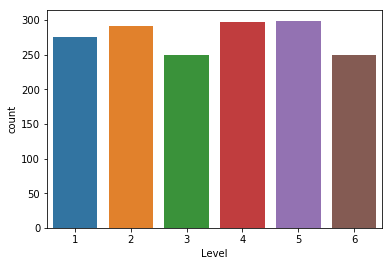

In [45]:
# Let's visualize the amount of files in each level
sns.countplot(x="Level", data=cepa_df)

We already know the value counts of the levels, but it doesn't hurt to visualize it! Levels 2, 4, and 5 have the most files, getting near to 300. It looks like 3 and 6 have the least amount of files.

Normally, we would expect the least amount of files in higher proficiencies. We would expect to see more files around a medium proficiency, and more low-level files than high-level files. We did see that for the most part in our original .jpg data: Levels 1, 2, 3, and 5 had 300 files each, Level 4 had 298, and Level 6 had 252 files.

Therefore, it looks like we "lost" the most data in Levels 1 and 3. Only a handful of files were dropped from the other levels.

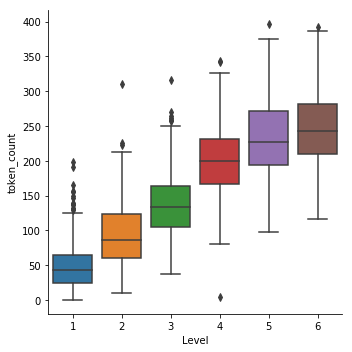

In [46]:
# Let's look at general length by level
sns.catplot(x='Level', y='token_count', kind='box', data=cepa_df)

In [47]:
lv1_tokct = cepa_df[cepa_df.Level == '1'].token_count # token count for level 1
lv2_tokct = cepa_df[cepa_df.Level == '2'].token_count # token count for level 2
lv3_tokct = cepa_df[cepa_df.Level == '3'].token_count # token count for level 3
lv4_tokct = cepa_df[cepa_df.Level == '4'].token_count # token count for level 4
lv5_tokct = cepa_df[cepa_df.Level == '5'].token_count # token count for level 5
lv6_tokct = cepa_df[cepa_df.Level == '6'].token_count # token count for level 6

stats.f_oneway(lv1_tokct, lv2_tokct, lv3_tokct, lv4_tokct, lv5_tokct, lv6_tokct)

F_onewayResult(statistic=764.373757392868, pvalue=0.0)

Here, we see something that's pretty expected! The higher level students typically write more than the lower level students. There's a handful of outliers, mostly in Level 1. The one-way ANOVA suggests that there is a significant difference between groups here, but we will have to investigate a little bit more to pinpoint exactly where/what it is.

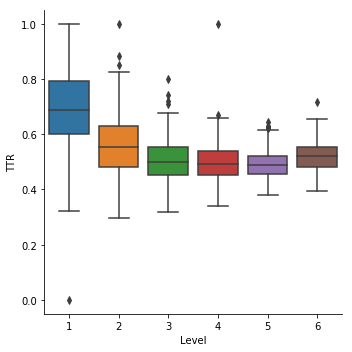

In [48]:
sns.catplot(x='Level', y='TTR', kind='box', data=cepa_df)

In [49]:
lv1_ttr = cepa_df[cepa_df.Level == '1'].TTR # ttr for level 1
lv2_ttr = cepa_df[cepa_df.Level == '2'].TTR # ttr for level 2
lv3_ttr = cepa_df[cepa_df.Level == '3'].TTR # ttr for level 3
lv4_ttr = cepa_df[cepa_df.Level == '4'].TTR # ttr for level 4
lv5_ttr = cepa_df[cepa_df.Level == '5'].TTR # ttr for level 5
lv6_ttr = cepa_df[cepa_df.Level == '6'].TTR # ttr for level 6

stats.f_oneway(lv1_ttr, lv2_ttr, lv3_ttr, lv4_ttr, lv5_ttr, lv6_ttr)

F_onewayResult(statistic=208.1989467995349, pvalue=1.6028012530002684e-172)

This really isn't too surprising! The higher the (perceived) level is, the more students seem to write. Conversely, becuase they're writing more, there's more of a likelihood that they'll repeat their words, especially when compared to much lower levels (1, 2). Of course, TTR tells us more when it's normalized/controlled for length, so maybe we can return to this later.

There's a few TTRs of or near 1.0, which means students didn't repeat _any_ words in their essays. Again, that's not too hard to do when you're writing very short essays! However, there's another thing to take into account here: we have seen from our work above that students make a _lot_ of spelling errors, and sometimes the same student will spell the same word several different ways in the same essay! So this measure of TTR still may not have the highest accuracy because students _may actually be repeating words_, but it isn't caught by the TTR function because they're misspelling the word, so they may appear to be different words. Just something to think about!

As with the token count, the one-way ANOVA suggests that there is a significant difference between groups here, though we'll still need to do some digging!

# Overview

So, I've done quite a bit here, I think! I read in all the CEPA files, accounting for duplicates; standardized the tagging in essays, and then removed it; and now I have some specific linguistic data to look at! The essays, tokens, token counts, and TTR so far. I would like to POS tag and possibly lemmatize still, but I think this is a good start.

From my brief (and admittedly pretty shallow) descriptive and quantitative analysis, I found that we still have a pretty good distribution of texts across the different levels. We found that get higher in (perceived) quality/proficiency, they tend to get longer, and their TTR tends to get lower. Again, this is expected, so that's not bad! Both of these differences appear to be signficant.